In [140]:
import abc
import base64
import copy
import numpy as np

In [141]:
class CategoricalCrossentropy():
    def __call__(self, y_true, y_pred):
        d = y_true.shape[0]
        return -1 / d * np.sum(y_true * np.log(y_pred))

    def gradient(self, y_true, y_pred):
        d = y_true.shape[0]
        return -1 * (y_true / y_pred)

    def gradient_with_softmax(self, y_true, y_pred):
        return y_pred - y_true

In [88]:
class Model(object):
    def __init__(self, loss=None, optimizer=None):
        self._layers = []
        self._loss = loss
        self._optimizer = optimizer
        self._outputs = None

    def add(self, layer):
        if not self._layers:
            layer.build(optimizer=self._optimizer)
        else:
            layer.build(self._layers[-1], optimizer=self._optimizer)
        self._layers.append(layer)

    def forward(self, inputs):
        outputs = inputs
        for layer in self._layers:
            outputs = layer.forward(outputs)
        self._outputs = outputs
        return self._outputs

    def backward(self, outputs, use_gradient_softmax_with_loss=False):
        if use_gradient_softmax_with_loss:
            grad_outputs = [self._loss.gradient_with_softmax(outputs[i], self._outputs[i]) for i in range(outputs.shape[0])]
            backward_layers = self._layers[:-1]
        else:
            grad_outputs = [self._loss.gradient(outputs[i], self._outputs[i]) for i in range(outputs.shape[0])]
            backward_layers = self._layers

        grad_outputs = np.array(grad_outputs)
        for layer in backward_layers[::-1]:
            grad_outputs = layer.backward(grad_outputs)

    def update_weights(self, x_batch, y_batch, use_gradient_softmax_with_loss=False):
        self.forward(x_batch)
        self.backward(y_batch, use_gradient_softmax_with_loss)
        for layer in self._layers[::-1]:
            layer.update_weights()

    def fit(self, X, Y, batch_size, epochs, shuffle = True, X_val = None, Y_val = None, use_gradient_softmax_with_loss=False):
        size = X.shape[0]
        X_train, y_train = X[:], Y[:]

        self.loss_train_history = []
        self.loss_val_history = []

        for epoch in range(1, epochs + 1):
            if shuffle:
                p = np.random.permutation(size)
                X_train, y_train = X[p], Y[p]
            for step in range(size // batch_size):
                ind_slice = slice(step * batch_size, (step + 1) * batch_size)
                self.update_weights(X_train[ind_slice], y_train[ind_slice], use_gradient_softmax_with_loss)
            train_loss = self.evaluate(X_train, y_train, batch_size)

            if (X_val is not None) and (Y_val is not None):
                val_loss = self.evaluate(X_val, Y_val, batch_size)
                self.loss_val_history.append(val_loss)
                self.loss_train_history.append(train_loss)
            else:
                self.loss_train_history.append(train_loss)

    def evaluate(self, X, Y, batch_size):
        Y_pred = np.empty(Y.shape)
        size = X.shape[0]
        for step in range(size // batch_size + 1):
            ind_slice = slice(step * batch_size, (step + 1) * batch_size)
            Y_pred[ind_slice] = self.forward(X[ind_slice])
        losses = [self._loss(Y[i], Y_pred[i]) for i in range(size)]
        return sum(losses) / len(losses)

In [89]:
class HeInitializer(object):
    def __call__(self, shape):
        n = shape[0]
        return np.random.randn(*shape) * np.sqrt(2.0 / n)


class ZerosInitializer(object):
    def __call__(self, shape):
        return np.zeros(shape)

In [90]:
class Layer(abc.ABC):
    def __init__(self, input_dim = None):
        self.input_dim = input_dim
        self.output_dim = None
        self.inputs = None
        self.outputs = None
        self.d_inputs = None
        self.d_outputs = None
        self._optimizer = None
        self._is_build = False

    def build(self, prev_layer=None, optimizer=None):
        self._optimizer = copy.deepcopy(optimizer)
        if prev_layer is not None:
            self.input_dim = prev_layer.output_dim
        self._is_build = True

    def forward(self, inputs):
        return self._forward(inputs)

    def backward(self, grad_outputs):
        return self._backward(grad_outputs)

    @abc.abstractmethod
    def _forward(self, inputs):
        pass

    @abc.abstractmethod
    def _backward(self, grad_outputs):
        pass

    @abc.abstractmethod
    def update_weights(self):
        pass

In [91]:
class Linear(Layer):
    def __init__(self, units, input_dim = None, weights_initializer = None, bias_initializer = None):
        super().__init__(input_dim)
        self.output_dim = units
        self.weights = None
        self.mean_d_weights = None
        self._weights_initializer = weights_initializer if weights_initializer else HeInitializer()
        self._bias_initializer = bias_initializer if bias_initializer else ZerosInitializer()

    def build(self, prev_layer = None, optimizer = None):
        super().build(prev_layer, optimizer)
        weights = self._weights_initializer((self.input_dim, self.output_dim))
        bias = self._bias_initializer((1, self.output_dim))
        self.weights = np.vstack((weights, bias))

    def _forward(self, inputs):
        self.inputs = inputs
        batches = inputs.shape[0]
        inputs = np.tile(inputs, (self.output_dim, 1, 1)).transpose((1, 2, 0))
        return (inputs * self.weights[ :-1, : ]).sum(axis = 1) + self.weights[-1, : ]

    def _backward(self, grad_outputs):
        batches = grad_outputs.shape[0]
        self.mean_d_weights = np.zeros(self.weights.shape)
        res = np.zeros((batches, self.input_dim))
        for i in range(batches):
            res[i, : ] = self.weights[ : -1, : ] @ grad_outputs[i]

        for i in range(batches):
            y = np.hstack((self.inputs[i], np.array([1])))
            z = grad_outputs[i]
            y_a = np.tile(y, (z.shape[0], 1))
            z_a = np.tile(z, (y.shape[0], 1))
            self.mean_d_weights += (z_a * y_a.T)
        self.mean_d_weights /= batches
        return res

    def update_weights(self):
        self.weights = self._optimizer.update_weights(
            self.weights, self.mean_d_weights)
        pass


class ReLU(Layer):
    def __init__(self, input_dim=None):
        super().__init__(input_dim)

    def build(self, prev_layer=None, optimizer=None):
        super().build(prev_layer, optimizer)
        self.output_dim = self.input_dim

    def _forward(self, inputs):
        self.inputs = inputs
        return (inputs > 0) * inputs

    def _backward(self, grad_outputs):
        return (self.inputs > 0) * grad_outputs

    def update_weights(self):
        pass


class Softmax(Layer):
    def __init__(self, input_dim = None):
        super().__init__(input_dim)

    def build(self, prev_layer = None, optimizer = None):
        super().build(prev_layer, optimizer)
        self.output_dim = self.input_dim

    def _forward(self, inputs):
        self.inputs = inputs
        t = np.exp(inputs)
        a = np.tile(t.sum(axis = 1), (inputs.shape[1], 1)).T
        return t / a

    def _backward(self, grad_outputs):
        batches, d = self.inputs.shape
        res = np.zeros(grad_outputs.shape)
        a = np.exp(self.inputs).sum(axis = 1)
        for k in range(batches):
            t = np.exp(self.inputs[k])
            res[k] = -np.dot(t * grad_outputs[k], np.tile(t, (d, 1))) + t * grad_outputs[k] * a[k] / a[k] ** 2
        return res

    def update_weights(self):
        pass

In [92]:
class SGD(object):
    def __init__(self, lr, t = 0.01):
        self._lr = lr
        self._t = t

    def update_weights(self, weights, gradient):
        return weights - self._t * gradient

In [93]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [94]:
def prepare_data(images, labels):
    binarizer = LabelBinarizer()
    X = images.reshape((images.shape[0], 28 * 28))
    y = binarizer.fit_transform(labels)
    return X / 255.0, y 

def create_mnist_model(loss, optimizer):
    model = Model(loss = loss, optimizer = optimizer)
    model.add(Linear(10, input_dim = 28 * 28))
    model.add(ReLU())
    model.add(Linear(10))
    model.add(Softmax())
    return model

In [95]:
(X_train, y_train),(X_val, y_val) = mnist.load_data()
X_train, y_train = prepare_data(X_train, y_train)
X_val, y_val = prepare_data(X_val, y_val)

In [132]:
import matplotlib.pyplot as plt
epoch_count = 10
batches = 10

model = create_mnist_model(loss = CategoricalCrossentropy(), optimizer = SGD(lr = 0.01))
model.fit(X_train[0: , ], y_train[0: , ], batches, epoch_count, X_val = X_val[0: , ], Y_val = y_val[0: , ])

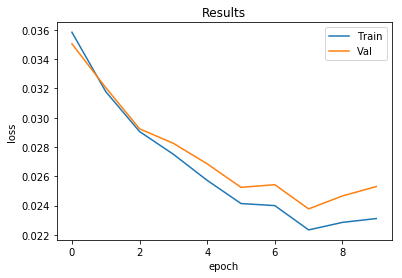

In [133]:
plt.title("Results")
plt.plot(range(epoch_count), model.loss_train_history, label = "Train");
plt.plot(range(epoch_count), model.loss_val_history, label = "Val");
plt.xlabel("epoch");
plt.ylabel("loss");
plt.legend()
plt.show();

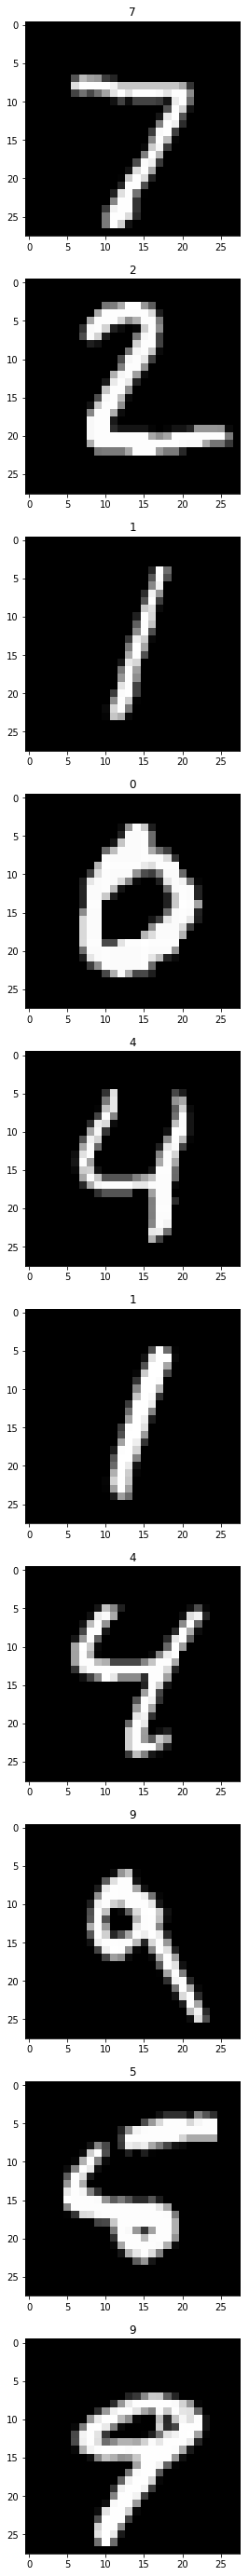

In [139]:
figure, axs = plt.subplots(10, 1, figsize=(100, 50), squeeze=False)
for i in range(10):
    axs[i][0].imshow(X_val[i].reshape([28, 28]))
    for j in range(10):
        if y_val[i][j]:
            axs[i][0].set_title(str(j))
plt.show()